# Capstone Project: Predicting additional tax revenue for the state of Connecticut if sports wagering is legalized

## Problem Statement

The State Legislature of Connecticut is reviewing a bill to legalize sports wagering within the state. The State Legislature must carefully weigh pros and cons when deciding pass or reject the bill. If they pass the bill, the bill moves on to the Sentate for final approval. If the Senate approves, Connecticut would become the 12th state in the United States where sports wagering has been legalized.

A major consideration by the State Legislature is the potential revenue gain in the State General fund. All sources of gaming share revenue with the state and make transfers into the State General fund at the end of the fiscal year. While sports wagering itsself is likely to bring in new revenue for the state, the state must consider reductions in other revenue streams that the new sports wagering revenue stream may cause. 

Using Sports Wagering year-end reports we have for each state where sports wagering was legal in 2019 as well as state annual reports showing other streams of revenue, we will build and leverage an unsupervised linear regression model that will help predict if legazing sports wagering will lead to an increase or decrease in total revenue for Connecticut, using the other states as prototypes. After modeling, we will exmaine the model's mean squared error, helping us determine the success of the model. Our goal is to provide the state with a model that can predict revenue as closely as possible, giving the state more confidence to make their decision more clear.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller  
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
pd.set_option('display.float_format', lambda x: '%.3f' % x)

np.random.seed(42)
sns.set_style("whitegrid")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_csv('./data/wv_combined.csv')

## Cleaning / EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 10 columns):
week_ending                53 non-null object
tickets_written            53 non-null int64
 voids                     53 non-null int64
tickets_cashed             53 non-null int64
mobile_taxable_receipts    31 non-null float64
retail_taxable_receipts    53 non-null int64
total_taxable_receipts     53 non-null int64
privilege_tax              53 non-null int64
admin_share                53 non-null int64
state_share                53 non-null int64
dtypes: float64(1), int64(8), object(1)
memory usage: 4.3+ KB


In [4]:
df.columns

Index(['week_ending', 'tickets_written', ' voids ', 'tickets_cashed',
       'mobile_taxable_receipts', 'retail_taxable_receipts',
       'total_taxable_receipts', 'privilege_tax', 'admin_share',
       'state_share'],
      dtype='object')

In [5]:
df.shape

(53, 10)

In [6]:
df.describe()

,tickets_written,voids,tickets_cashed,mobile_taxable_receipts,retail_taxable_receipts,total_taxable_receipts,privilege_tax,admin_share,state_share
count,53.000,53.000,53.000,31.000,53.000,53.000,53.000,53.000,53.000
mean,3195297.132,68707.057,3834779.019,170215.161,261617.094,361176.925,36117.679,5417.642,30700.075
std,1182310.138,31901.788,2274218.808,221671.646,372453.863,499461.807,49946.174,7491.924,42454.302
min,206602.000,3387.000,201539.000,-571570.000,-844841.000,-1416411.000,-141641.000,-21246.000,-120395.000
25%,2176969.000,44266.000,1890579.000,35048.000,67688.000,146359.000,14636.000,2195.000,12441.000
50%,3680379.000,67621.000,3554777.000,149607.000,243657.000,284627.000,28463.000,4269.000,24193.000
75%,4164430.000,91090.000,5622406.000,276460.000,401287.000,674009.000,67401.000,10110.000,57291.000
max,4902465.000,154935.000,9404206.000,601782.000,1388791.000,1664244.000,166424.000,24964.000,141461.000


In [7]:
df.dtypes

week_ending                 object
tickets_written              int64
 voids                       int64
tickets_cashed               int64
mobile_taxable_receipts    float64
retail_taxable_receipts      int64
total_taxable_receipts       int64
privilege_tax                int64
admin_share                  int64
state_share                  int64
dtype: object

In [8]:
df['week_ending'] = pd.to_datetime(df['week_ending'])

In [9]:
df.dtypes

week_ending                datetime64[ns]
tickets_written                     int64
 voids                              int64
tickets_cashed                      int64
mobile_taxable_receipts           float64
retail_taxable_receipts             int64
total_taxable_receipts              int64
privilege_tax                       int64
admin_share                         int64
state_share                         int64
dtype: object

In [10]:
test = ' voids '
test.strip()

'voids'

In [11]:
df.columns = [col.strip() for col in df.columns]

In [12]:
df.isnull().sum().sort_values(ascending = False)

mobile_taxable_receipts    22
state_share                 0
admin_share                 0
privilege_tax               0
total_taxable_receipts      0
retail_taxable_receipts     0
tickets_cashed              0
voids                       0
tickets_written             0
week_ending                 0
dtype: int64

In [13]:
df[df.isna().any(axis=1)]

,week_ending,tickets_written,voids,tickets_cashed,mobile_taxable_receipts,retail_taxable_receipts,total_taxable_receipts,privilege_tax,admin_share,state_share
10,2019-03-16,2858410,70218,2565896,nan,222296,222296,22230,3334,18895
11,2019-03-23,4418971,91090,3554777,nan,773104,773104,77310,11597,65714
12,2019-03-30,3443807,67494,3025699,nan,350615,350615,35061,5259,29802
13,2019-04-06,2385379,68355,2123295,nan,193729,193729,19373,2906,16467
16,2019-04-27,2607302,49943,2587349,nan,-29989,-29989,-2999,-450,-2549
17,2019-05-04,2296202,38167,1856748,nan,401287,401287,40129,6019,34109
18,2019-05-11,2210385,30720,2190474,nan,-10808,-10808,-1081,-162,-919
19,2019-05-18,2176969,44266,1975717,nan,156986,156986,15699,2355,13344
20,2019-05-25,1984382,31461,1885233,nan,67688,67688,6769,1015,5754
21,2019-06-01,2036091,22197,1691982,nan,321912,321912,32191,4829,27363


In [14]:
df.fillna(0, inplace=True)

In [15]:
df.isnull().sum().sort_values(ascending = False)

state_share                0
admin_share                0
privilege_tax              0
total_taxable_receipts     0
retail_taxable_receipts    0
mobile_taxable_receipts    0
tickets_cashed             0
voids                      0
tickets_written            0
week_ending                0
dtype: int64

In [16]:
df.set_index('week_ending', inplace=True)

### Visualizing (this won't be an actual section)

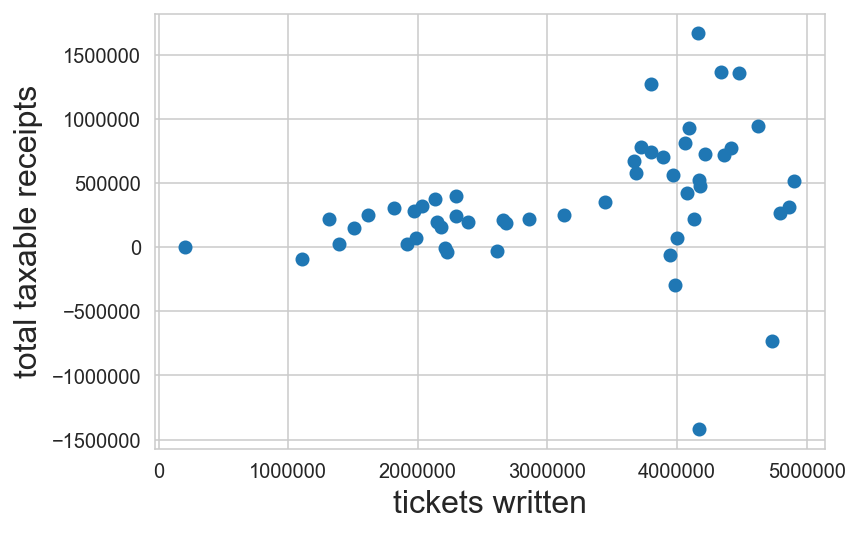

In [17]:
plt.scatter(df["tickets_written"], df["total_taxable_receipts"])
plt.xlabel("tickets written", fontsize = 16)
plt.ylabel("total taxable receipts", fontsize = 16);

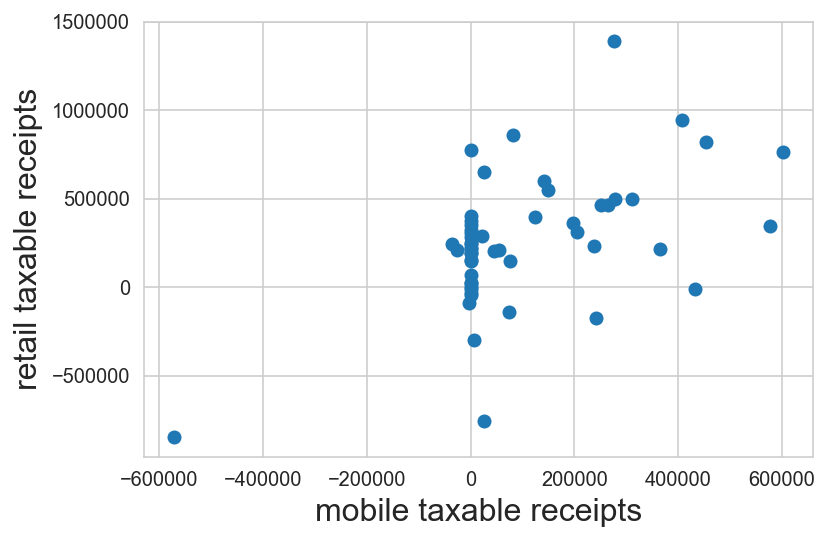

In [18]:
plt.scatter(df['mobile_taxable_receipts'], df['retail_taxable_receipts'])
plt.xlabel("mobile taxable receipts", fontsize = 16)
plt.ylabel("retail taxable receipts", fontsize = 16);

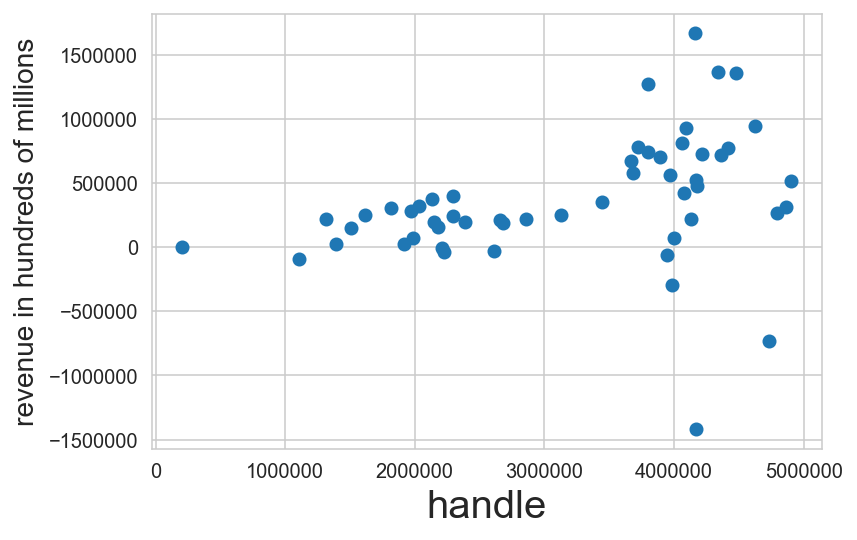

In [19]:
plt.scatter(df['tickets_written'], df['total_taxable_receipts'])
plt.xlabel('handle', fontsize = 20)
plt.ylabel('revenue in hundreds of millions', fontsize = 14);

In [20]:
df.dtypes

tickets_written              int64
voids                        int64
tickets_cashed               int64
mobile_taxable_receipts    float64
retail_taxable_receipts      int64
total_taxable_receipts       int64
privilege_tax                int64
admin_share                  int64
state_share                  int64
dtype: object

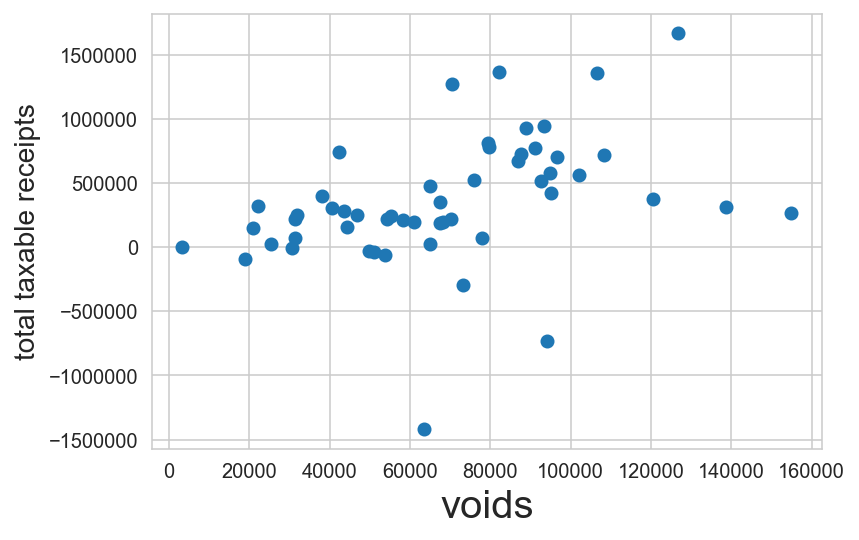

In [21]:
plt.scatter(df['voids'], df['total_taxable_receipts'])
plt.xlabel('voids', fontsize = 20)
plt.ylabel('total taxable receipts', fontsize = 14);

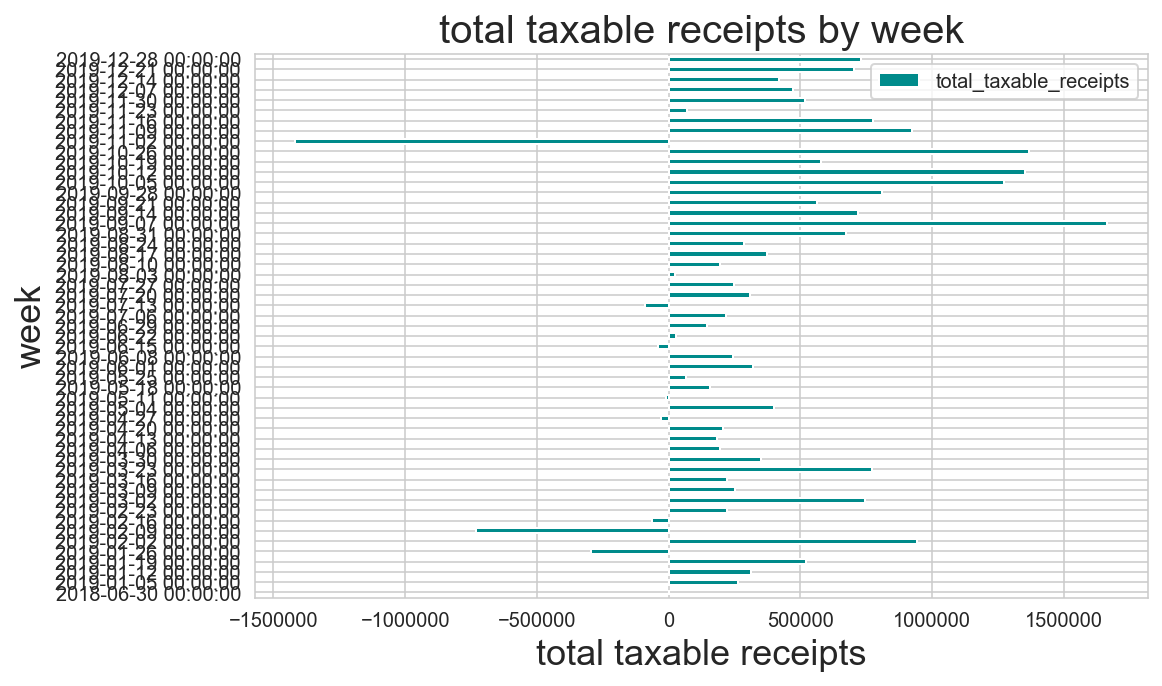

In [22]:
# obviously change this

df.groupby("week_ending")[["total_taxable_receipts"]].mean().plot(kind = "barh", color="darkcyan", figsize=(8,5))
plt.ylabel("week", fontsize=18)
plt.xlabel("total taxable receipts", fontsize=18)
plt.title("total taxable receipts by week", fontsize=20);

In [23]:
df.groupby("month")[["revenue"]].mean().plot(kind = "barh", color="darkcyan", figsize=(8,5))
plt.ylabel("month", fontsize=18)
plt.xlabel("revenue", fontsize=18)
plt.title("revenue by month", fontsize=20);

KeyError: 'month'

In [ ]:
# Heatmap of the corrleations of features and revenue
plt.figure(figsize = (10,14))
sns.heatmap(df.corr()[["revenue"]].sort_values(by = 'revenue', ascending = False),
                            annot = True,
                            cmap="RdBu",
                            vmin = -1,
                            vmax = 1);

## Preprocessing 

### One-hot Encoding

### PCA


In [ ]:
non_revenue_cols = ["month", "handle", "taxes"]

In [ ]:
# Assigning the new columns to a variable

non_revenue_cols_2 = df[non_revenue_cols]

In [ ]:
non_revenue_cols_2.head()

In [ ]:
ss = StandardScaler()

In [ ]:
scale = ss.fit_transform(non_revenue_cols_2)

In [ ]:
non = pd.DataFrame(scale, columns = non_revenue_cols)

In [ ]:
non.head(10)

### Using a PairGrid to visualize correlation

In [24]:
g = sns.PairGrid(non)
g = g.map_lower(sns.regplot) # Regression plots in lower triangle.
g = g.map_upper(sns.kdeplot, cmap="Blues", shade=True, shade_lowest=False)  # KDE plots in upper triangle.
g = g.map_diag(plt.hist) # Histograms along diagonal.

plt.show();

NameError: name 'non' is not defined

### Heat map to visualize correlation

NameError: name 'non' is not defined

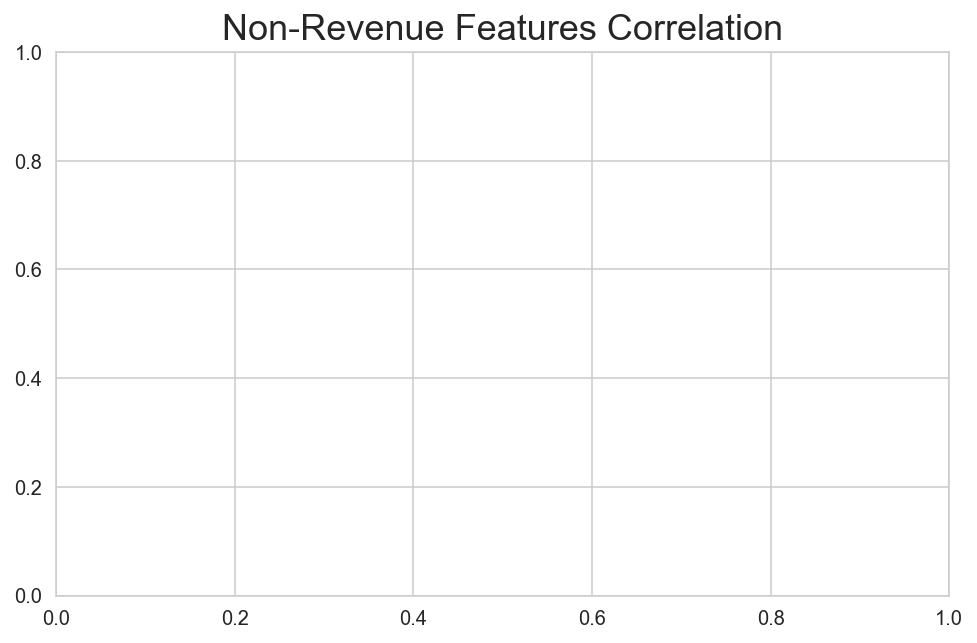

In [25]:
plt.figure(figsize = (8, 5))
plt.title("Non-Revenue Features Correlation", fontsize = 18);


sns.heatmap(non.corr(), 
            cmap ='RdBu', 
            annot = True,
            vmax = 1,
            vmin = -1)
            
plt.xticks(fontsize = 12) 
plt.yticks(fontsize = 12); 

In [ ]:
# Fitting PCA on the non-revenue features

non_pca = PCA(n_components=3)
non_pca.fit(non.values)

In [26]:
# Examining the weights of the principal components

non_pca.components_

NameError: name 'non_pca' is not defined

In [27]:
# Examining the explained variance values and explained variance ratios

non_pca.explained_variance_ratio_

NameError: name 'non_pca' is not defined

In [28]:
# Transforming the data into the principal component space

# This will transform our our three-dimensional data set into vectors along its three principal components (with zero loss).

non_pca.transform(non.values)

NameError: name 'non_pca' is not defined

In [29]:
# Comparing PCA-transformed features to features prior to being PCA-transformed

In [ ]:
pd.DataFrame(non.values).head(10)

In [ ]:
pd.DataFrame(non_pca.transform(non.values)).head(10)

### Using PCA ro reduce dimensionality

## Modeling

In [ ]:
X = df.loc[:, ['month', 'revenue', 'handle', 'taxes']]

In [ ]:
X.head()

In [ ]:
# For my reference

state_revenue_plot = df.plot(kind = "scatter", x = "month", y = "revenue",
             figsize=(10,5),
             s = 12)

plt.xlabel("month", fontsize = 15)
plt.ylabel("revenue", fontsize = 15)

state_revenue_plot.tick_params(axis = 'both',
               which = 'minor',
               labelsize = 14)

In [ ]:
# Initializing an instance of KMeans
# K = 3 clusters

km = KMeans(n_clusters = 3)

In [ ]:
# Fitting our sliced df

km.fit(X)

In [ ]:
# Assigning clusters

df["cluster"] = km.labels_

In [ ]:
df.head(10)

In [ ]:
# Plotting the centroids from the model object with the scatter of 
# "month" and "revenue"

centroid = pd.DataFrame(km.cluster_centers_, columns = ["month", "revenue", "handle", "taxes"])
                                        

In [ ]:
centroid.head()

Plotting methodology:

1. Setting the plot figure with a fig size
2. Assigning colors to centroids
3. Mapping clusters
4. Setting up the plot of clusters
5. Adding the centroids to the plot

In [ ]:
plt.figure(figsize =(10, 8))
colors = ["black", "pink", "blue"]
df["color"] = df["cluster"].map(lambda p: colors[p])

ax = df.plot(kind = "scatter", x = "month", y = "revenue",
    figsize =(12, 10),
    c = df["color"])

centroid.plot(kind = "scatter", x = "month", y = "revenue", 
    marker = "*", 
    c = ["black", "pink", "blue"], 
    s = 1000,
    ax = ax)

Scaling Methodology:

1. Set up StandardScaller
2. Set up X feature and transforming it
3. Set up KMeans
4. Fitting
5. Assinging next round of clusters
6. Creating a df for next round of centroids
7. Plotting

In [ ]:
ss = StandardScaler()

In [ ]:
X_2 = ss.fit_transform(df.loc[:, ["month", "revenue"]])

In [ ]:
km_2 = KMeans(n_clusters = 3)

In [ ]:
km_2.fit(X_2)

In [ ]:
df['cluster'] = km_2.labels_

In [ ]:
df.head(10)

In [ ]:
centroid = pd.DataFrame(ss.inverse_transform(km_2.cluster_centers_), 
      columns =["month", "revenue"])

In [ ]:
centroid.head(10) 

In [ ]:
plt.figure(figsize=(10,6))

colors = ["black", "pink", "blue"]

df['color'] = df['cluster'].map(lambda p: colors[p])

ax = df.plot(    
    kind = "scatter",  x = "month", y = "revenue", 
    figsize = (10,6),
    c = df["color"])

centroid.plot(kind = "scatter", x ="month", y = "revenue",
    marker = "*", 
    c = ["black", "pink", "blue"],
    s = 1000,
    ax = ax)

In [ ]:
silhouette_score(X_2, km_2.labels_)

### Time Series

In [44]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMA
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller  
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [45]:
df.head()

,tickets_written,voids,tickets_cashed,mobile_taxable_receipts,retail_taxable_receipts,total_taxable_receipts,privilege_tax,admin_share,state_share
week_ending,,,,,,,,,
2019-01-05,4796300,154935,4376920,54089.0,210356,264445,26445,3967,22478
2019-01-12,4860953,138666,4411529,21356.0,289402,310758,31076,4661,26414
2019-01-19,4167883,75981,3572071,122956.0,396875,519831,51983,7797,44186
2019-01-26,3983320,73280,4202907,6185.0,-299052,-292867,-29287,-4393,-24894
2019-02-02,4622730,93425,3585239,81104.0,862961,944066,94407,14161,80246


In [ ]:
df.set_index('week_ending', inplace=True)


In [ ]:
df.head()

In [ ]:
# Code written by Joseph Nelson. ARIMA Lesson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [ ]:
# Cite the source

def ACF_PACF(df, col_string, lags):
    ACF = plot_acf(df[col_string], lags = lags);
    PACF = plot_pacf(df[col_string], lags = lags);
    return ACF, PACF

## Time Series Modeling

In [ ]:
# Extracting data to model
#Aggregate all of the sales for STORE 1 into a new dataframe called Weekly_Sales.



# Create mask for "Store 1" and apply to data.
mask = data['Store'] == 1
data = data[mask]

# Create dataframe called `Weekly_Sales`.
Weekly_Sales = pd.DataFrame(data['Weekly_Sales'].groupby(data.index).sum())

In [ ]:
Weekly_Sales.head()


In [ ]:
# Plotting & Interpreting Time Series
# Generate a line plot for Weekly_Sales with time on the x-axis

plt.figure(figsize=(16,10))

# Create line plot.
plt.plot(Weekly_Sales, c ='green')

# Set labels and title.
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Date', fontsize=22)
plt.ylabel('Sales', fontsize=22)
plt.title('Weekly Sales for Store One', fontsize=22);

In [ ]:
#Calculate the rolling mean(s) for Weekly_Sales then plot them on a single set of axes.

# Set a rolling mean with windows of 1, 4, and 13.
rolmean1  = Weekly_Sales.rolling(window = 1).mean()
rolmean4  = Weekly_Sales.rolling(window = 4).mean()
rolmean13 = Weekly_Sales.rolling(window = 13).mean()

# Plot
plt.figure(figsize=(16,10))
plt.plot(rolmean1, color='blue', label='Rolling Mean (1 week)')
plt.plot(rolmean4, color='orange', label='Rolling Mean (4 week)')
plt.plot(rolmean13, color='grey', label='Rolling Mean (13 week)')

plt.legend(loc='best')

plt.title('Rolling Mean for 1, 4 and 13 Months')
plt.show()

#### Interpretation of plot above

There are clearly spikes in the early year around January and February. This is most likely the result of huge increases for holiday spending in November and December.
These spikes are followed, indicating a significant decrease in spending immediately following the holiday season.
We plot moving averages of 1, 4, and 13 weeks.
1 week is our default.
4 weeks is approximately one month.
13 weeks is approximately one season.

In [ ]:
# Checking three lag intervals

print(f'Autocorrelation between Weekly Sales and 1-lag Weekly_Sales: {round(Weekly_Sales["Weekly_Sales"].autocorr(lag=1),4)}')
print(f'Autocorrelation between Weekly Sales and 2-lag Weekly_Sales: {round(Weekly_Sales["Weekly_Sales"].autocorr(lag=2),4)}')
print(f'Autocorrelation between Weekly Sales and 52-lag Weekly_Sales: {round(Weekly_Sales["Weekly_Sales"].autocorr(lag=52),4)}')

#### What I am able to say about the series based on the autocorrelations

The single week autocorrelation shows that there is a fair amount of influence on sales each week from the prior week.
Looking at week two, it seems that the further away from the current week, we look back, the less influence that week's sales have on the current week's sales. It would be likely to consider that a lag of three would be even less correlated with the current week's sales.
The 52-week lag of sales is strongly correlated with the current week's sales. This would suggest that there might be a seasonal influence working on sales separated by one year.

In [ ]:
# Plotting the Autocorrelation Function and Partial Autocorrelation Functions to help
# understand seasonality in the time series data

# 52-week  Autocorr and Partial Autocorr
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(211)
fig = plot_acf(Weekly_Sales, lags=52, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(Weekly_Sales, lags=52, ax=ax2);

# If you do not use plt.show() it will plot the same vizualization twice.
# This may be a bug you can fix and submit to contribute to open source!


#### Interpretation of the ACF and PACF plots above

4a. What do the ACF and PACF graphs tell you about your sales data?

Answer:

The filled blue space is representative of a 95% confidence interval. The points inside the blue space are likely to be noise, not any valuable correlation. Points outside the interval should be considered for further investigation.

The first point is meaningless: it represents the correlation between the Weekly_Sales and itself, so the correlation here should always be 1.

At lag = 1, there is some relationship between the sales and prior day sales evidenced by both the ACF and PACF.
At lag = 4, there seems to be a correlation in both the ACF and PACF, this might be due to a monthly sales promotion or some kind of monthly cycle in sales.
At lag = 5 there is an interesting negative relationship which we cannot immediately infer about in the PACF (direct with no in-between relationships).
At lag = 48, 50, 51, and 52 there is significant positive relationship in the PACF, possibly a correlation to monthly sales, within the seasonality of a year.
At lag = 52, there is a clear correlation in both the ACF and PACF. This should give us a sense that there might be a seasonal component in the series.

#### How the ACF and PACF inform my model selections moving forward

We recognize that there is some correlation at 1 week, at 4 or 5 weeks, and right around one year (48-52 weeks).

This might help us determine our values of $p$ and $q$, as well as any seasonal component we might fit.





#### Modeling with time series data

Modeling with time series data presents unique challenges because our observations are not independent of one another.

So, in splitting the data into training and test sets, we cannot split randomly. Use the first 75% of observations as training data and the following 25% for test data.

In [ ]:
print(f'Number of observations: {len(Weekly_Sales)}')
print(f'Number of training observations: {round(len(Weekly_Sales) * 0.75)}')
print(f'Number of testing observations: {len(Weekly_Sales) - round(len(Weekly_Sales) * 0.75)}')

train = Weekly_Sales.iloc[:108,]

test = Weekly_Sales.iloc[108:,]

In [ ]:
def train_test_plot(train, test):
    plt.figure(figsize=(16, 8))
    plt.plot(train, c='blue')
    plt.plot(test, c='orange');

In [ ]:
# This plot confirms that our function works properly.
# The gap between the train and test is to be expected
# because we aren't connecting the dots between our
# 107th and 108th observations.

train_test_plot(train, test)

#### AR moodel

In [ ]:
# Instatiate and fit AR1 model

# Split training data into train values and dates.
train_values = train['Weekly_Sales'].values
train_dates = train.index

# Fit model on training data.
AR1 = AR(train_values, train_dates).fit()

# Split test data into values and dates.
test_values = test['Weekly_Sales'].values
test_dates  = test.index

# Create start and end dates for predictions
start = test.index[0]
end = test.index[-1]

# Generate predictions on starting and ending dates.
AR1_pred = AR1.predict(start = start,
                       end = end)

In [ ]:
# Put predictions into a dataframe with a date range

date_list =  pd.date_range(start, periods=35, freq ='W')
preds = pd.DataFrame(AR1_pred, index=date_list, columns = ['Weekly Sales'])

In [ ]:
# Calculate MSE of the model on training and test

# Calculate MSE.
error = mean_squared_error(test_values, preds)
print(f'MSE: {round(error, 2)}')

In [ ]:
# Look at min and max sales, as well as how our MSE compares to them

print(f'Minimum Sales: {round(Weekly_Sales["Weekly_Sales"].min(),2)}')
print(f'Maximum Sales: {round(Weekly_Sales["Weekly_Sales"].max(),2)}')
print(f'MSE relative to minimum values in series: {round(error / Weekly_Sales["Weekly_Sales"].min(),2)}.')
print(f'MSE relative to maximum values in series: {round(error / Weekly_Sales["Weekly_Sales"].max(),2)}.')


#### How effective was the model?

Looking at the ratio of the mean error to the minimum and maximum values in the series, it does not seem terrible. However (as we'll see shortly), when you look at the decay in the predictions based on the graph, it is clear that earlier predictions have less erroneous than later predictions, so improvement is probably necessary to use this model as is.

#### Residual Plot

Mean squared error is a good way to evaluate our model's performance. However, this doesn't tell the whole story. Is our model off by a lot in one specific window of time? Is our model only slightly off, but over all time? It might be helpful to plot residuals to see when our model is off most.

In [ ]:
# Calculating and plotting the residuals of the AR model
# A residual is just the actual value minus the predicted value

# Set figure size.
plt.figure(figsize=(16,10))

# Calculate residuals.
resids = test['Weekly_Sales'].values - preds['Weekly Sales'].values

# Generate scatterplot of residuals.
plt.scatter(test['Weekly_Sales'].index, resids, c ='red')

# Plot baseline at y=0.
plt.hlines(y = 0,
           xmin = test['Weekly_Sales'].index.min(),
           xmax = test['Weekly_Sales'].index.max(),
           linestyles = '--')

# Set labels and axes.
plt.xticks(fontsize=20)
plt.xlim(test['Weekly_Sales'].index.min(), test['Weekly_Sales'].index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 20);

#### Interpretation: What do the residual plots reveal about our model?

There are some days where the prediction is off more than others. This could be specific to those days, or it could be a limit of the model. It looks like early time periods are predicting too low (residuals = true - predicted values are high) and later time periods are predicting closer to accurate (residuals centered around 0).

#### ARMA model

In [ ]:
# Fit an AR(2) model.
AR2 = ARIMA(endog = train_values,
            dates = train_dates,
            order = (2,0,0)).fit()

# Generate predictions.
AR2_pred = AR2.predict(start = start,
                       end = end)

# Evaluate our model on the trainign and testing sets.
print(f'Training MSE: {mean_squared_error(train_values, AR2.predict())}')
print(f'Testing MSE: {mean_squared_error(test_values, AR2_pred)}')

preds = pd.DataFrame(AR2_pred, index=date_list, columns = ['Weekly Sales'])

train_test_plot(train, preds)

In [ ]:
# Set figure size.
plt.figure(figsize=(16,10))

# Calculate residuals.
resids = test['Weekly_Sales'].values - preds['Weekly Sales'].values

# Generate scatterplot of residuals.
plt.scatter(test['Weekly_Sales'].index, resids, c ='red')

# Plot baseline at y=0.
plt.hlines(y = 0,
           xmin = test['Weekly_Sales'].index.min(),
           xmax = test['Weekly_Sales'].index.max(),
           linestyles = '--')

# Set labels and axes.
plt.xticks(fontsize=20)
plt.xlim(test['Weekly_Sales'].index.min(), test['Weekly_Sales'].index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 20);

#### Did the results change?

The results got worse. Looking at the line plot, it seems as though the model removed all variation in the sales, creating a set of flat predictions.

In [ ]:
# AR